# Analyse the quality score of  `.fastq` reads generated with Sanger or Artic primers

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

#load reusable functions
from library_functions import extract_error_probs
from statsmodels.nonparametric.smoothers_lowess import lowess

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

## Settings

In [2]:
dir_base = os.path.expanduser("~/WGS/analyses/Sanger_vs_Artic/")
dir_figs = dir_base+"figs"
print(dir_figs)

if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
    print("Making output directory: %s" % dir_figs)

/home/dan/WGS/analyses/Sanger_vs_Artic/figs


## Separate out reads by barcode

In [24]:
# Is it possible to run guppy within this environment to parse out the data by barcode?

In [25]:
# cat all fastq files to be assessed into individual files
fq_artic = dir_base+"data/C2_BC06.fastq"
fq_sanger = dir_base+"data/C2_BC08.fastq"

## Look at quality of fastq reads

In [26]:
#run function to extract the errors
ep_artic = extract_error_probs(fq_artic)

In [27]:
#run function to extract the errors
ep_sanger = extract_error_probs(fq_sanger)

## Look at average read length

In [28]:
def count_lengths(seq_list):
    """
    Count the length of each read in an array
    
    params
        seq_list : list of arrays
            each record should relate to a single base
    
    returns
            lengths : array
                length of each array
                
    """
    lengths = []
    for p in seq_list:
        length = len(p)
        lengths.append(length)
    print("Average length = "+str(np.average(lengths))+", Stdev ="+str(np.std(lengths)))
    return(lengths)

In [29]:
len_artic = count_lengths(ep_artic)

Average length = 504.0467966740444, Stdev =16.27588443455685


In [30]:
len_sanger = count_lengths(ep_sanger)

Average length = 1077.2992358569318, Stdev =50.710634120562176


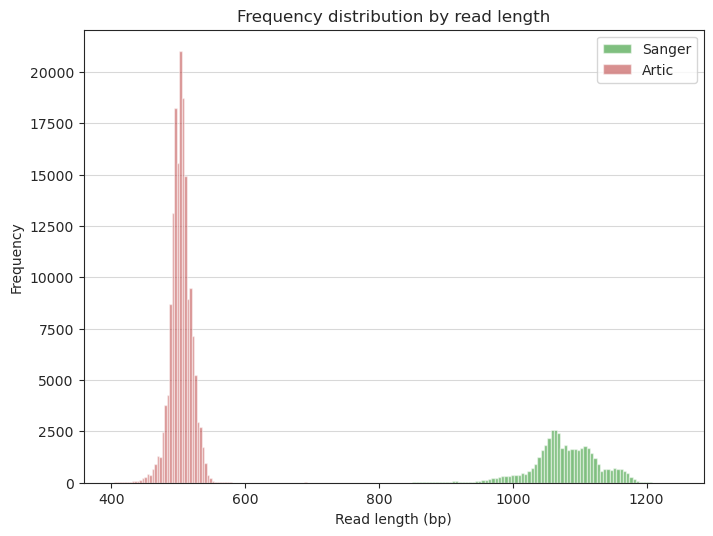

In [33]:
plt.figure(figsize=(8,6))

n_bins=80

plt.hist(len_sanger, bins=n_bins, alpha=0.5, label="Sanger", color="green")
plt.hist(len_artic, bins=n_bins, alpha=0.5, label="Artic", color="firebrick")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Read length (bp)')
plt.ylabel('Frequency')
plt.title('Frequency distribution by read length')
plt.legend(loc='upper right')
plt.show()

## Look at quality score across reads

- Too many points to plot individual reads and don't want to make any assumptions
    - Use a non-parameter smoothing method called LOWESS
- For LOWESS we need to give x-values to each read (position)

In [11]:
def ep_smooth(error_probs):
    """
    Smooth error_probs across list of sequences by nt
    
    params
        error_probs : list of arrays
            error probs for each base in list os seq arrays
    
    returns
        ep_smooth : array
                array of all positions
                
    """
    positions = []
        
    for p in error_probs:
        positions.append(np.arange(len(p)))
    #Concatenate list arrays
    cat_ep = np.concatenate(error_probs)
    cat_pos = np.concatenate(positions) 
    #Plot data with lowess function
    n_smooth = 10**6
    ps_smooth = lowess(endog=cat_ep[:n_smooth], 
                   exog=cat_pos[:n_smooth],
                   frac=0.1)
    return(ps_smooth)

In [12]:
smooth_artic = ep_smooth(ep_artic)

In [13]:
smooth_sanger = ep_smooth(ep_sanger)

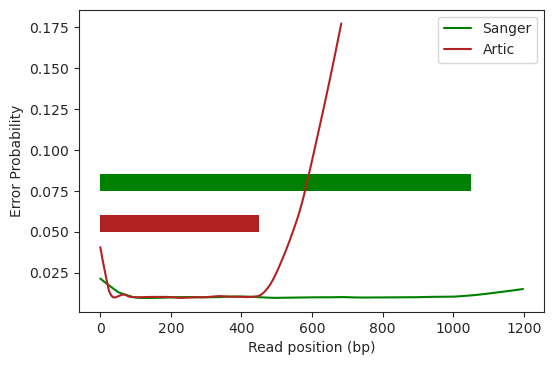

In [59]:
fig, ax = plt.subplots(1, 1)

#Plot error probs by base position
ax.plot(smooth_sanger[:, 0], smooth_sanger[:, 1], color='green', label="Sanger")
ax.plot(smooth_artic[:, 0], smooth_artic[:, 1], color='firebrick', label="Artic")
ax.legend()
ax.set_xlabel("Read position (bp)")
ax.set_ylabel("Error Probability")

# Draw rectangles to show expected seq length
rect1 = patches.Rectangle((0,0.05),450,0.01,linewidth=1,edgecolor='none',facecolor='firebrick')
rect2 = patches.Rectangle((0,0.075),1050,0.01,linewidth=1,edgecolor='none',facecolor='green')
ax.add_patch(rect1)
ax.add_patch(rect2)

plt.show()